In [1]:
!pip install tensorflow-gpu==2.10.0

In [50]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.applications.vgg16 import preprocess_input
from tqdm import tqdm
from tensorflow.keras.layers.experimental import preprocessing
# from keras.preprocessing import image
import os
pd.options.display.max_columns = 50

In [2]:
if 'COLAB_TPU_ADDR' in os.environ:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print("Running on TPU ", resolver.master())
else:
    strategy = tf.distribute.get_strategy() # Default strategy

In [3]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

2024-04-26 18:05:38.082812: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 18:05:38.344620: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-26 18:05:38.344692: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-89-186.ap-south-1.compute.internal): /proc/driver/nvidia/version does not exist


In [4]:
tf. __version__

'2.10.0'

In [5]:
train_df = pd.read_csv('Training_Set/Training_Set/RFMiD_Training_Labels.csv')
val_df = pd.read_csv('Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv')
test_df = pd.read_csv('Test_Set/Test_Set/RFMiD_Testing_Labels.csv')

In [6]:
train_df.head()

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,CWS,CB,ODPM,PRH,MNF,HR,CRAO,TD,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
train_df['img_path'] = [f'Training_Set/Training_Set/Training/{id}.png' for id in train_df['ID']]
val_df['img_path'] = [f'Evaluation_Set/Evaluation_Set/Validation/{id}.png' for id in val_df['ID']]
test_df['img_path'] = [f'Test_Set/Test_Set/Test/{id}.png' for id in test_df['ID']]

In [8]:
train_df = train_df.drop(labels=['ID'],axis=1)

In [9]:
train_df = train_df.drop(labels=['Disease_Risk','ODPM', 'HR'], axis=1)
val_df = val_df.drop(labels=['ID', 'Disease_Risk', 'ODPM', 'HR'], axis=1)
test_df = test_df.drop(labels=['ID', 'Disease_Risk', 'ODPM', 'HR'], axis=1)

In [10]:
train_df.columns

Index(['DR', 'ARMD', 'MH', 'DN', 'MYA', 'BRVO', 'TSLN', 'ERM', 'LS', 'MS',
       'CSR', 'ODC', 'CRVO', 'TV', 'AH', 'ODP', 'ODE', 'ST', 'AION', 'PT',
       'RT', 'RS', 'CRS', 'EDN', 'RPEC', 'MHL', 'RP', 'CWS', 'CB', 'PRH',
       'MNF', 'CRAO', 'TD', 'CME', 'PTCR', 'CF', 'VH', 'MCA', 'VS', 'BRAO',
       'PLQ', 'HPED', 'CL', 'img_path'],
      dtype='object')

In [11]:
Y_train = list(train_df.drop(['img_path'], axis=1).columns)
Y_val = list(val_df.drop(['img_path'], axis=1).columns)
Y_test = list(test_df.drop(['img_path'], axis=1).columns)
unq_disease = len(Y_train)

In [12]:
print(unq_disease)

43


In [13]:
Y_train

['DR',
 'ARMD',
 'MH',
 'DN',
 'MYA',
 'BRVO',
 'TSLN',
 'ERM',
 'LS',
 'MS',
 'CSR',
 'ODC',
 'CRVO',
 'TV',
 'AH',
 'ODP',
 'ODE',
 'ST',
 'AION',
 'PT',
 'RT',
 'RS',
 'CRS',
 'EDN',
 'RPEC',
 'MHL',
 'RP',
 'CWS',
 'CB',
 'PRH',
 'MNF',
 'CRAO',
 'TD',
 'CME',
 'PTCR',
 'CF',
 'VH',
 'MCA',
 'VS',
 'BRAO',
 'PLQ',
 'HPED',
 'CL']

In [14]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_dataframe(train_df,
                                              x_col='img_path',
                                              y_col=Y_train,
                                              target_size=(150,150),
                                              class_mode='raw',
                                              batch_size=32,
                                              shuffle=True)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_dataframe(val_df,
                                          x_col='img_path',
                                          y_col=Y_val,
                                          target_size=(150,150),
                                          class_mode='raw',
                                          batch_size=32)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_dataframe(test_df,
                                            x_col='img_path',
                                            y_col=Y_test,
                                            target_size=(150,150),
                                            class_mode='raw')

Found 1920 validated image filenames.
Found 640 validated image filenames.
Found 640 validated image filenames.


In [15]:
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomContrast([0, 0.2]),
#   preprocessing.RandomHeight(0.2),
#   preprocessing.RandomWidth(0.2),
  preprocessing.Rescaling(1./255)
], name ="data_augmentation")

In [16]:
from keras.applications import VGG16

# Instantiate VGG16 model
base_model = VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False
)

# Set the model to non-trainable
base_model.trainable = False


In [17]:
def Model(inputs):

    augData = data_augmentation(inputs)

    x = base_model(augData, training=False)

    # Convert features of shape `base_model.output_shape[1:]` to vectors
    x = keras.layers.GlobalAveragePooling2D()(x)

    # output
    x = tf.keras.layers.Flatten()(x)
    x= tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01))(x) # L1 Regularization
    x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01))(x) # L1 Regularization
    out = tf.keras.layers.Dense(units=unq_disease, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=[inputs], outputs=[out])
    return model

In [18]:
auc = tf.keras.metrics.AUC(multi_label=True, name="AUROC", thresholds=[0,0.1])
# aucpr = tf.keras.metrics.AUC(curve='PR',multi_label=True)
precision = tf.keras.metrics.Precision(thresholds=0.1)
bac = tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy",
    threshold=0.1
)

inputs = keras.layers.Input(shape=(150,150,3))
with strategy.scope():
    model = Model(inputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[auc, bac, precision])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 150, 150, 3)      0         
 al)                                                             
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664 

In [19]:
history=model.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10


2024-04-24 01:23:23.286971: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 184320000 exceeds 10% of free system memory.
2024-04-24 01:23:23.667203: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 184320000 exceeds 10% of free system memory.
2024-04-24 01:23:24.781639: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 92160000 exceeds 10% of free system memory.
2024-04-24 01:23:25.202687: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 92160000 exceeds 10% of free system memory.


 1/60 [..............................] - ETA: 16:15 - loss: 39.6629 - AUROC: 0.1512 - binary_accuracy: 0.0247 - precision: 0.0247

2024-04-24 01:23:30.748323: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 184320000 exceeds 10% of free system memory.


60/60 [==============================] - 672s 11s/step - loss: 22.1172 - AUROC: 0.5020 - binary_accuracy: 0.2347 - precision: 0.0280 - val_loss: 8.4175 - val_AUROC: 0.4400 - val_binary_accuracy: 0.8134 - val_precision: 0.0804
Epoch 2/10
60/60 [==============================] - 674s 11s/step - loss: 3.4228 - AUROC: 0.5065 - binary_accuracy: 0.8513 - precision: 0.1070 - val_loss: 1.1628 - val_AUROC: 0.4419 - val_binary_accuracy: 0.8681 - val_precision: 0.1174
Epoch 3/10
60/60 [==============================] - 675s 11s/step - loss: 0.6106 - AUROC: 0.5005 - binary_accuracy: 0.8851 - precision: 0.1316 - val_loss: 0.3267 - val_AUROC: 0.4419 - val_binary_accuracy: 0.9088 - val_precision: 0.1449
Epoch 4/10
60/60 [==============================] - 676s 11s/step - loss: 0.2828 - AUROC: 0.5001 - binary_accuracy: 0.9143 - precision: 0.1546 - val_loss: 0.2568 - val_AUROC: 0.4419 - val_binary_accuracy: 0.9088 - val_precision: 0.1449
Epoch 5/10
60/60 [==============================] - 669s 11s/step 

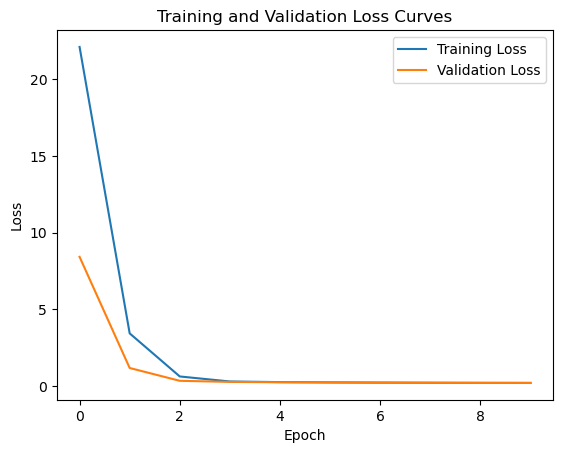

In [20]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

In [21]:
model.evaluate(test_gen)

20/20 [==============================] - 176s 9s/step - loss: 0.1853 - AUROC: 0.4070 - binary_accuracy: 0.9291 - precision: 0.1661


[0.18527691066265106,
 0.40697672963142395,
 0.929142415523529,
 0.16614583134651184]

In [22]:
(images, labels) = test_gen.next()

In [23]:
history =model.predict(images)

1/1 [==============================] - 5s 5s/step


In [68]:
test_image_path="Test_Set/Test_Set/Test/108.png"
# Load the image using keras.preprocessing.image module
test_image = load_img(test_image_path, target_size=(150, 150))

# Convert the image to a numpy array
test_image_array = img_to_array(test_image)

# Expand the dimensions to match the input shape expected by the model
test_image_array = np.expand_dims(test_image_array, axis=0)

# Normalize the image pixel values
test_image_array = test_image_array / 255.0

# Perform inference using the model
predictions = model.predict(test_image_array)

# Decode the predictions to get disease labels
predicted_labels = [Y_test[i] for i in range(len(Y_test)) if predictions[0][i] >= 0.1]

# Get the actual disease labels from the test dataframe
image_row = test_df[test_df['img_path'].str.contains(test_image_path.split('/')[-1])]

# Extract the actual disease labels from the row
actual_labels = image_row.iloc[:, :-1].values.flatten().tolist()

# Extract the actual disease labels where the value is 1
actual_disease_labels = [Y_test[i] for i, label in enumerate(actual_labels) if label == 1]

# Print the predicted and actual disease labels
print("Predicted Disease Labels:", predicted_labels)
print("Actual Disease Labels:", actual_disease_labels)


1/1 [==============================] - 0s 326ms/step
Predicted Disease Labels: ['DR', 'MH', 'ODC']
Actual Disease Labels: ['MH', 'RT']


In [25]:
!pip install lime

  0%|          | 0/1000 [00:00<?, ?it/s]

Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x7f7629fd2b00>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x7f7629fd2b00>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original err

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


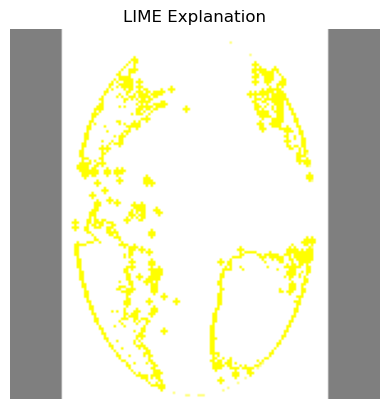

In [94]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Define a function to preprocess the image for LIME
def lime_preprocess_img(img_path):
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img)
    return img_array

# Define a function to predict with your model (wrapped in a lambda function for compatibility with LIME)
predict_fn = lambda img_array: model.predict(img_array)

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Choose an image to explain (you can change this to any image from your test set)
image_index = 0
image_path = test_df['img_path'][image_index]

# Preprocess the image
img_array = lime_preprocess_img(image_path)

# Explain the prediction for the chosen image
explanation = explainer.explain_instance(img_array, predict_fn, top_labels=1, hide_color=0, num_samples=1000)

# Get the explanation for the top class
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

# Plot the original image with the LIME explanation overlaid
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title('LIME Explanation')
plt.axis('off')
plt.show()


In [29]:
model.save("best_model.h5")

In [23]:
from keras.models import load_model
model=load_model("best_model.h5")